In [ ]:
#!/usr/bin/env python 
import sys
import os
import time
import subprocess as sp
import itertools
## CV
import cv2
## Model
import numpy as np
# import tensorflow as tf
## Tools
import utils
## Parameters
import params ## you can modify the content of params.py
import imageio
from utils import without_ext,ext,mkv_to_mp4
import h5py

%load_ext autoreload
%autoreload 2


Using TensorFlow backend.


In [2]:
print(cv2.__version__)

3.1.0


## Convert mkv to jpg

In [3]:
## Test epoch

vid_path = utils.join_dir(params.data_dir, 'epoch{:0>2}_front.mkv'.format(1))
vid_path

'/Users/zouxiaxia/Documents/Study/Projects/deep_tesla/epochs/epoch01_front.mkv'

In [4]:
from utils import without_ext,ext,mkv_to_mp4

mkv_to_mp4(vid_path, remove_mkv=False)    

vid_mp4_path = os.path.splitext(vid_path)[0]+'.mp4'
vid_mp4_path

'/Users/zouxiaxia/Documents/Study/Projects/deep_tesla/epochs/epoch01_front.mp4'

In [6]:
import imageio

time0 = time.time()

filename = vid_mp4_path
vid = imageio.get_reader(filename,'ffmpeg')

images_01 = []
for num in range(len(vid)):
    images_01.append(vid.get_data(num))
    
# len(images)

time1 = time.time()
print(time1-time0)

9.596287965774536


In [180]:
# import cv2
# print(cv2.__version__)

time0 = time.time()

vidcap = cv2.VideoCapture(vid_mp4_path)
success,image = vidcap.read()
count = 0
success = True
images = []
while success:    
    success,image = vidcap.read()
#     if count%10 == 0:    
#         print('Read a new frame: ', success)
#         print(count+1)
#     cv2.imwrite("/Users/zouxiaxia/Documents/Study/Projects/deep_tesla/train_images/frame%d.jpg" % count, image)     # save frame as JPEG file
#     count += 1
    images.append(image)
vidcap.release()

time1 = time.time()
print(time1-time0)

KeyboardInterrupt: 

## Process data

(720, 1280, 3)


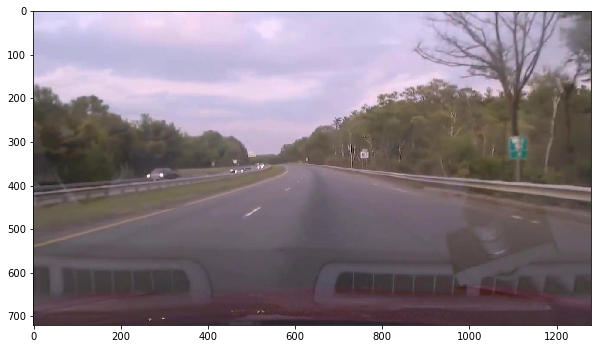

In [1]:
from scipy.misc import imread
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10,6))
file_path = './images_10epoch/epoch10_426_front.jpg'
exp_img = imread(file_path)
plt.imshow(exp_img)
print(exp_img.shape)

(330, 1280, 3)


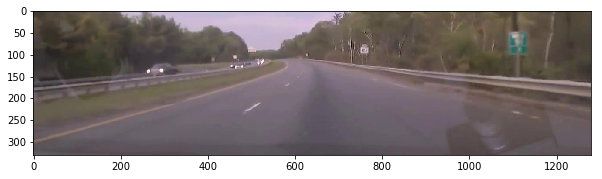

In [3]:
shape = exp_img.shape
img_crop = exp_img[int(shape[0]/3):shape[0]-150, 0:shape[1]]

plt.figure(figsize=(10,6))
plt.imshow(img_crop)
print(img_crop.shape)

(66, 200, 3)


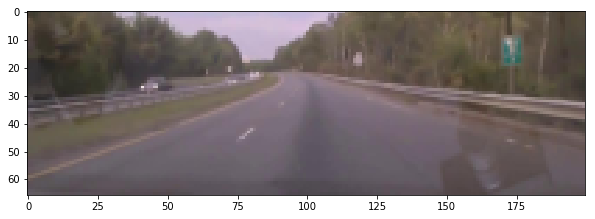

In [5]:
import cv2

img_resize = cv2.resize(img_crop, (200, 66), interpolation=cv2.INTER_AREA)
plt.figure(figsize=(10,6))
plt.imshow(img_resize)
print(img_resize.shape)

test time used

In [176]:
import time

time0 = time.time()
images_process =  [img_pre_process(img) for img in images[:1000]]
images_ready = np.stack(images_process, axis=0)
time1 = time.time()

In [179]:
print("time for processing 1000 images: %.3f "%(time1-time0))

time for processing 1000 images: 4.127 


那么整理9 epochs的train data和 10-epoch test data, need (2700\*10/1000\*4.127s/60)=1.85715m

### Process train YUV dataset

In [10]:
def crop_resize_image(img):
    # Crop
    shape = img.shape
    img_crop = img[int(shape[0]/3):shape[0]-150, 0:shape[1]]
    
    # Resize the image
    img_resize = cv2.resize(img_crop, (200, 66), interpolation=cv2.INTER_AREA)
    
    assert img_resize.shape == (66,200,3)
    
    return img_resize

def YUV_normal_image(img,YUV=True):
    if YUV:
        # RGB to YUV
        img_yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)

        # Normalize, need int???
        return img_yuv/255.0
    else:
        return img/255.0
    
def add_shadow(img,orient='vertical'):
    h, w = img.shape[:2]
    
    if orient=='vertical':
        [x1, x2] = np.random.choice(w, 2, replace=False)
        k = h / (x2 - x1) # slope
        b = - k * x1      # y intercept 
        for i in range(h):
            c = int((i - b) / k)
            img[i, :c, :] = (img[i, :c, :] * .5) #.astype(np.int32)

    elif orient=='horizontal':
        [y1, y2] = np.random.choice(h, 2, replace=False)
        k = w / (y2 - y1) # slope
        b = - k * y1      # x intercept 
        for i in range(w):
            c = int((i - b) / k)
            img[:c, i, :] = (img[:c, i, :] * .5) #.astype(np.int32)

    return img

In [5]:
def add_shadow_images(idx, images, steerings, add_new=True):
    
    from math import ceil 
    rand_idx = np.random.choice(len(idx), ceil(len(idx)*0.2), replace=False)
    shadow_idx = idx[rand_idx]
    
    if add_new:
        
        idx_v = shadow_idx[:len(shadow_idx)//2]  
        idx_h = shadow_idx[len(shadow_idx)//2:]

        # add vertical shadow
        images_new_v = [add_shadow(img,'vertical') for img in images[idx_v]] # list
        images_new_v = np.stack(images_new_v, axis=0)   #numpy array
        steerings_new_v = steerings[idx_v]
        assert images_new_v.shape[1:]==(66,200,3)
        assert steerings_new_v.shape[0] == images_new_v.shape[0]
        
        # add horizontal shadow
        images_new_h = [add_shadow(img,'horizontal') for img in images[idx_h]] # list
        images_new_h = np.stack(images_new_h, axis=0)   #numpy array
        steerings_new_h = steerings[idx_h]
        assert images_new_h.shape[1:]==(66,200,3)
        assert steerings_new_h.shape[0] == images_new_h.shape[0]
        
        # combine
        images = np.concatenate((images, images_new_v,images_new_h), axis=0)
        steerings = np.concatenate((steerings,steerings_new_v,steerings_new_h), axis=0)
        assert images.shape[1:]==(66,200,3)
        assert steerings.shape[0] == images.shape[0]
        
        return images, steerings
    else:
        cnt = 0
        for i in shadow_idx:
            if cnt< (len(shadow_idx)//2):
                images[i] = add_shadow(images[i],'vertical')
                
            else:
                images[i] = add_shadow(images[i],'horizontal')
            cnt+=1
        assert images.shape[1:]==(66,200,3)
        assert steerings.shape[0] == images.shape[0]
        
        return images, steerings

In [16]:
import time

def process_epoch_data(epoch_id, YUV=True, flip=True, shadow=True):
    print('---------- processing video for epoch {} ----------'.format(epoch_id))
    vid_mkv_path = utils.join_dir(params.data_dir, 'epoch{:0>2}_front.mkv'.format(epoch_id))
    
    # convert mkv to mp4
    vid_mp4_path = utils.join_dir(params.data_dir, 'epoch{:0>2}_front.mp4'.format(epoch_id))
    if not os.path.exists(vid_mp4_path):
        mkv_to_mp4(vid_mkv_path, remove_mkv=False)    
    
    # slice mp4 to images
    vid = imageio.get_reader(vid_mp4_path,'ffmpeg')
    images = []
    for num in range(len(vid)):
#     for num in range(200):        
        images.append(vid.get_data(num))
    print('epoch{:0>2}_front.mkv has {} images'.format(epoch_id,len(images)))
    
    ## Crop and Resize before data agumentation
    images = [crop_resize_image(img) for img in images]
    images = np.stack(images, axis=0)
    
    
    # get steerings from csv file
    steerings = process_epoch_csv(epoch_id)
    
    print("images: ",len(images))
    print("steerings: ",steerings.shape)
    print("\t")

    # do flip agumentation
    if flip:
        print('--------------------start flip images--------')
        t0 = time.time()
        # steering not equal 0, flip
        flip_idx = np.where(steerings!=0)[0]  
        images_flip = images[flip_idx, :, ::-1, :]
        steering_flip = -steerings[flip_idx]
        
        print("images_flip num: ", images_flip.shape)
        print("steering_flip num: ", steering_flip.shape)
        
        # combine images_flip and images
        images = np.concatenate((images, images_flip), axis=0)
        steerings = np.concatenate((steerings,steering_flip), axis=0)
        
        print("combine images num: ", images.shape)
        print("combine steerings num: ", steerings.shape)
        
        print("---------------------flip images using time: ",time.time()-t0)
    
    
    # shadow agumentation
    if shadow:
        print("-------------------start adding shadow-------")
        t0 = time.time()
        # abs(steering) > 2, copy images, add shadowon new iamges
        idx_new = np.where(np.abs(steerings)>2)[0] 
        # add shadow if num >3
        if len(idx_new)>3:
            images, steerings = add_shadow_images(idx_new, images, steerings, add_new=True)
        # abs(steering) <= 2, add shadow on original images
        idx_old = np.where(np.abs(steerings)<=2)[0]  
        if len(idx_old)>3:
            images, steerings = add_shadow_images(idx_old, images, steerings, add_new=False)
        
        print("images num after shadow : ", images.shape)
        print("steerings num after shadow: ", steerings.shape)
        print("--------------------adding shadow using time: ",time.time()-t0)

    
    #yuv, normalization        
    images = [YUV_normal_image(img, YUV) for img in images]
    images = np.stack(images, axis=0)
    print("epoch {} has {} images after process: ".format(epoch_id,images.shape[0]))
                       
    assert np.max(images) <=1
    assert np.min(images) >=0
    return images,steerings

最后输出数据前，对采样 -0.5,,0.5 flip过了

sample 2400*2 when abs(steering)=0.5
```
        flip_s = np.where(np.abs(steerings)==0.5)[0]
        flip_rest = np.where(np.abs(steerings)!=0.5)[0]
        print(len(flip_s))
        
        sample_idx = np.random.choice(len(flip_s), 2400*2, replace=False)
        flip_sample_idx = flip_s[sample_idx]
        
        total_idx = np.concatenate((flip_rest, flip_sample_idx), axis=0)
        images = images[total_idx]
        steerings= steerings[total_idx]
        
        print("combine images", images.shape)
        print("combine steerings", steerings.shape)
```

In [239]:
%time images,steerings = process_epoch_data(10)

---------- processing video for epoch 10 ----------
epoch10_front.mkv has 200 images
---------- processing csv file for epoch 10 ----------
images:  200
steerings:  (200,)
	
--------------------start flip images--------
images_flip num:  (200, 66, 200, 3)
steering_flip num:  (200,)
combine images num:  (400, 66, 200, 3)
combine steerings num:  (400,)
---------------------flip images using time:  0.06735801696777344
-------------------start adding shadow-------
images num after shadow :  (437, 66, 200, 3)
steerings num after shadow:  (437,)
--------------------adding shadow using time:  0.1350390911102295
epoch 10 has 437 images after process: 
CPU times: user 1.17 s, sys: 649 ms, total: 1.82 s
Wall time: 3.01 s


In [230]:
images.shape

(437, 66, 200, 3)

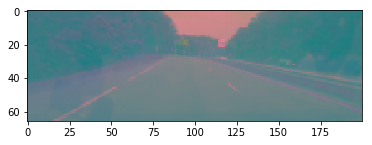

In [236]:
 plt.imshow(images[230])

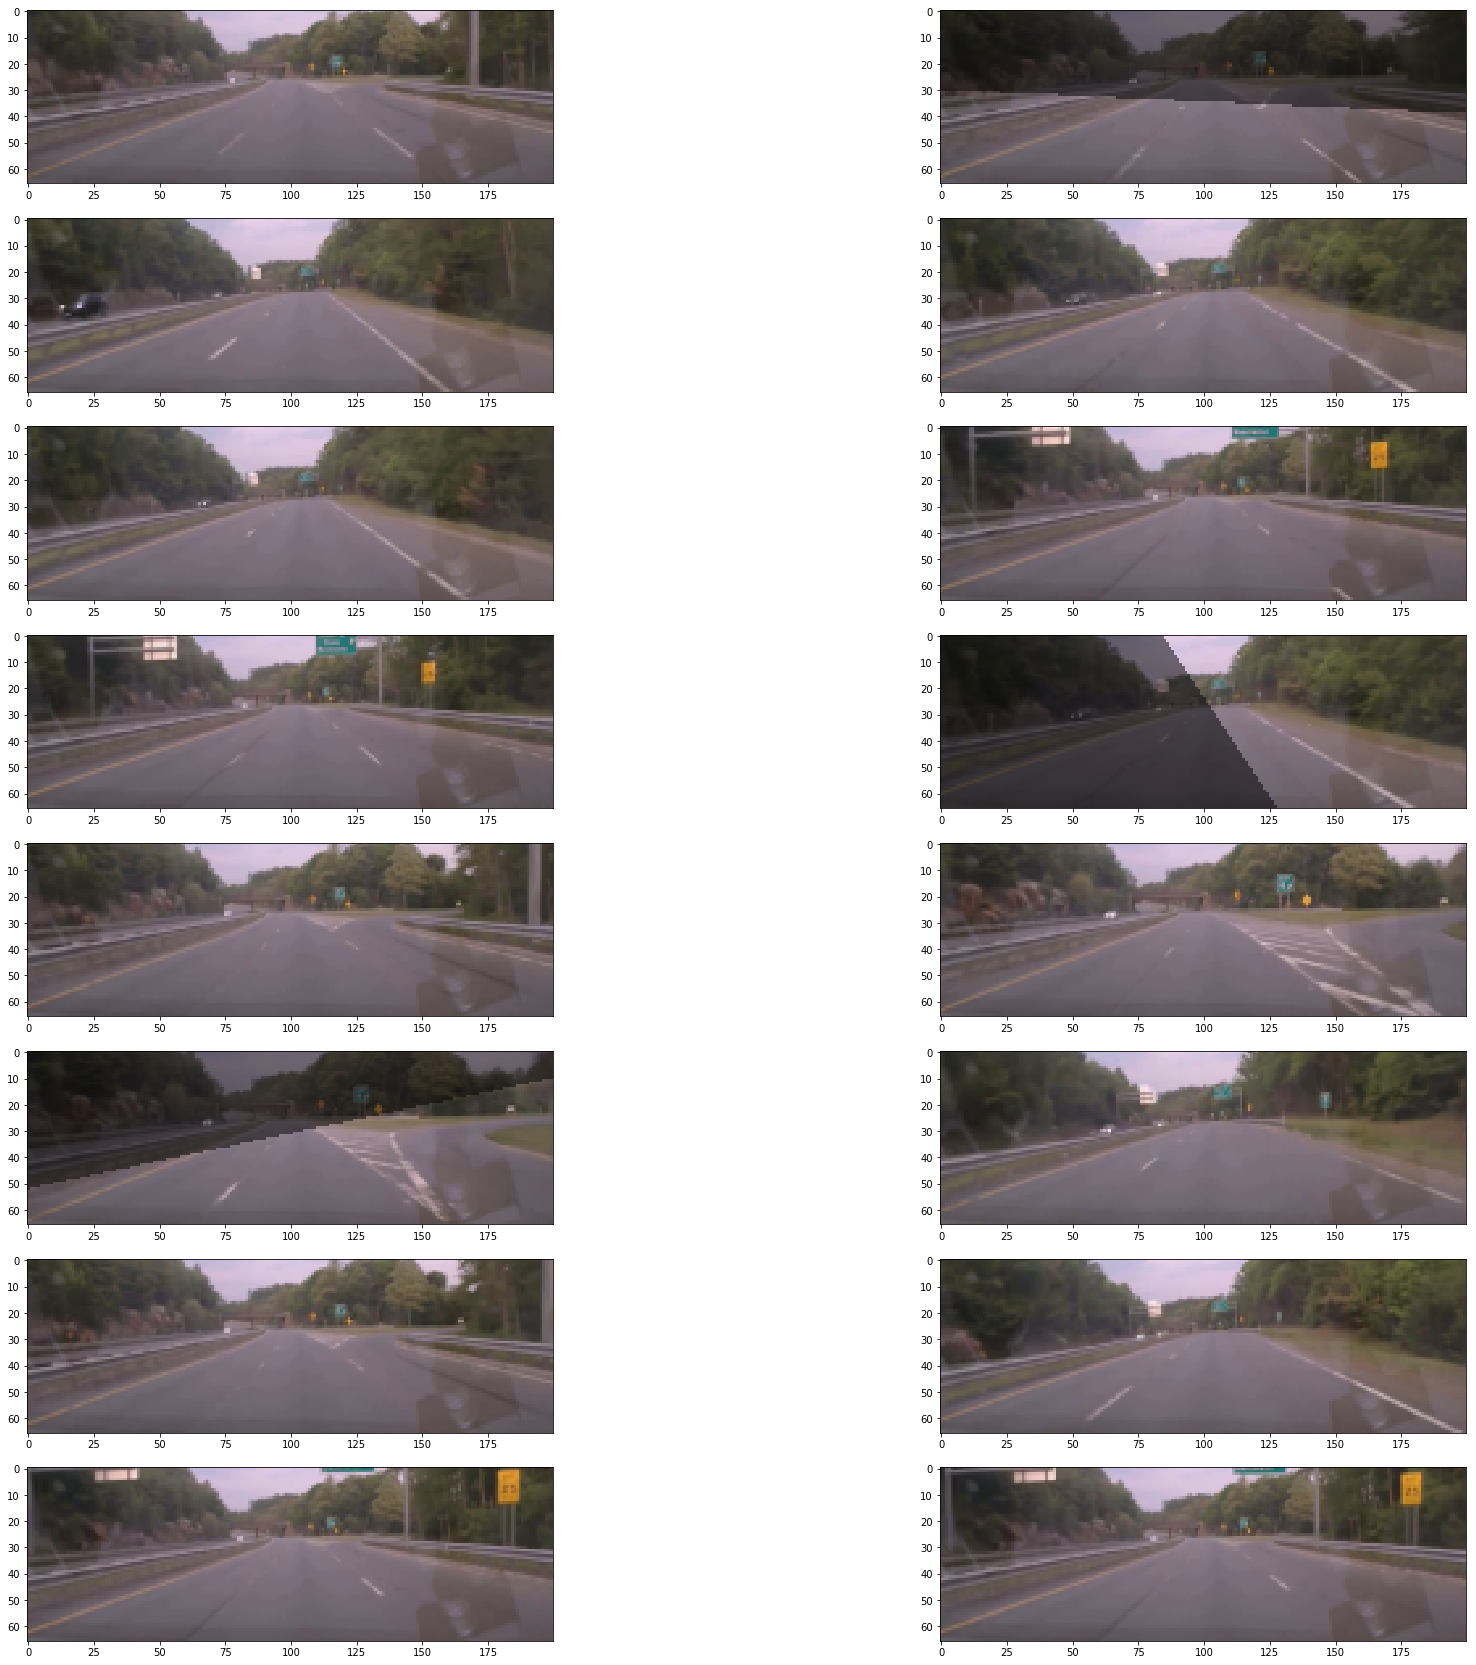

In [226]:
plt.figure(figsize=(30, 30))

for i,idx in enumerate(np.random.choice(200,16, replace=False)):
    img = images[idx]
                 
    plt.subplot(8, 2, i+1)
    plt.imshow(img)


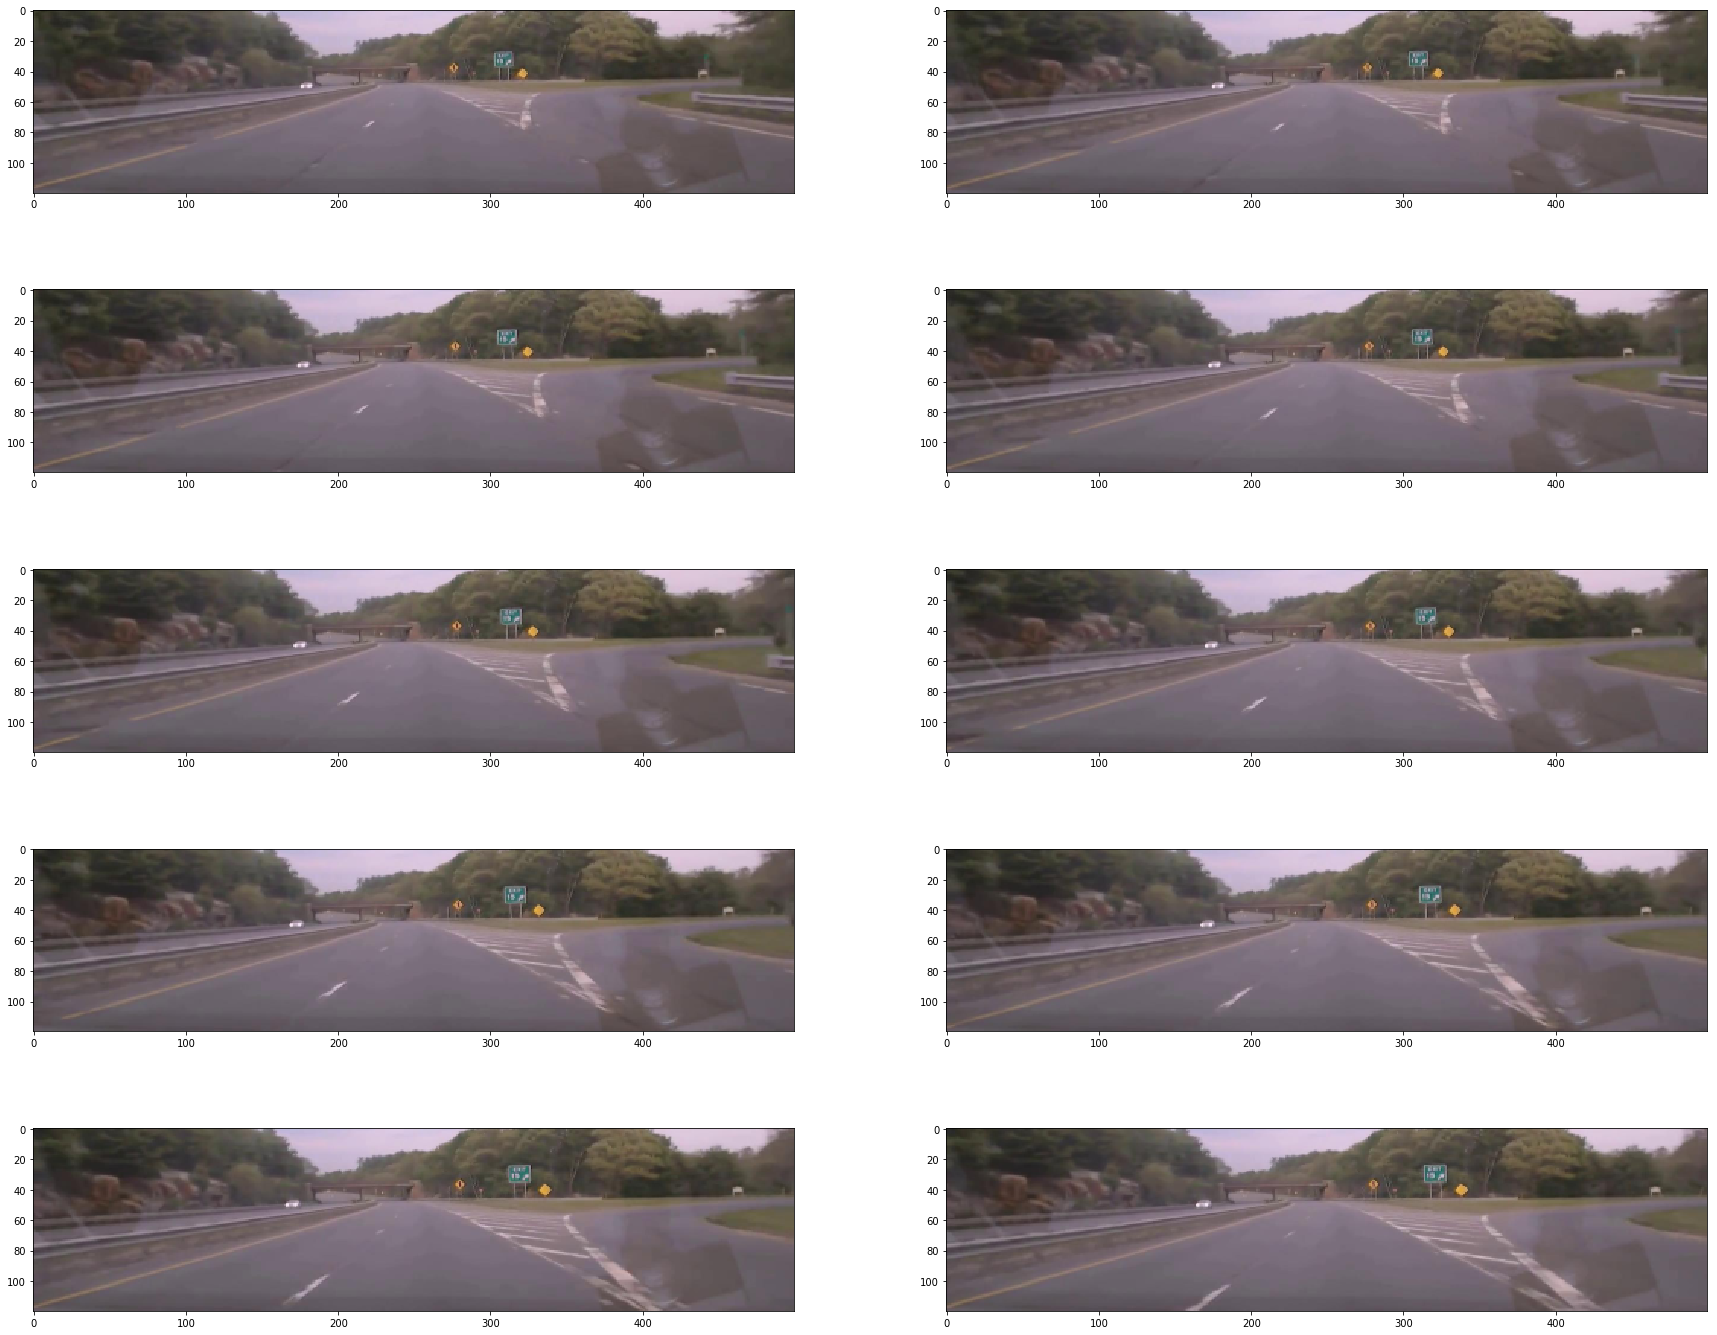

In [116]:
plt.figure(figsize=(30, 30))
# fig, ax = plt.subplots(5, 1)


for i,idx in enumerate(range(180,190)):
    img = imread('./images_10epoch/epoch10_{}_front.jpg'.format(idx))
    shape = img.shape
    img_crop = img[int(shape[0]/3):shape[0]-150, 0:shape[1]]
    
    # Resize the image
    img_resize = cv2.resize(img_crop, (500, 120), interpolation=cv2.INTER_AREA)
#     ax[i].set_title("frame:"+str(idx+1) +" mse:" +str(error))
#     ax[i].imshow(img_resize)
                 
    plt.subplot(6, 2, i+1)
    plt.imshow(img_resize)
    


In [ ]:
images, steerings = process_epoch_data(1)
print(images.shape)
print(steerings.shape)

In [17]:
# images_train = np.vstack(images_epochs)
epoch_ids=range(1,10)

images_train=[]
steerings_train =[]
for epoch_id in epoch_ids:
    images, steerings = process_epoch_data(epoch_id)
    images_train.append(images)
    steerings_train.append(steerings)
    
images_train = np.concatenate(images_train, axis=0)
steerings_train = np.concatenate(steerings_train, axis=0)

del images
del steerings

---------- processing video for epoch 1 ----------
epoch01_front.mkv has 1500 images
---------- processing csv file for epoch 1 ----------
images:  1500
steerings:  (1500,)
	
--------------------start flip images--------
images_flip num:  (1405, 66, 200, 3)
steering_flip num:  (1405,)
combine images num:  (2905, 66, 200, 3)
combine steerings num:  (2905,)
---------------------flip images using time:  0.28457212448120117
-------------------start adding shadow-------
images num after shadow :  (3237, 66, 200, 3)
steerings num after shadow:  (3237,)
--------------------adding shadow using time:  0.6980891227722168
epoch 1 has 3237 images after process: 
---------- processing video for epoch 2 ----------
epoch02_front.mkv has 3900 images
---------- processing csv file for epoch 2 ----------
images:  3900
steerings:  (3900,)
	
--------------------start flip images--------
images_flip num:  (3487, 66, 200, 3)
steering_flip num:  (3487,)
combine images num:  (7387, 66, 200, 3)
combine steerin

In [18]:
print("totaly images_train", images_train.shape)
print("totaly steerings_train", steerings_train.shape)
print(np.max(images_train))
print(np.min(images_train))


totaly images_train (51022, 66, 200, 3)
totaly steerings_train (51022,)
1.0
0.0235294117647


In [22]:
idx_sample = np.where(np.abs(steerings_train)==0.5)[0]
mask = np.random.choice(len(idx_sample), len(idx_sample)-2400*2, replace=False)
images_train = np.delete(images_train, mask, axis=0)
steerings_train = np.delete(steerings_train, mask, axis=0)

print("totaly images_train", images_train.shape)
print("totaly steerings_train", steerings_train.shape)
print(np.max(images_train))
print(np.min(images_train))


totaly images_train (46600, 66, 200, 3)
totaly steerings_train (46600,)
1.0
0.0235294117647


In [27]:
# shuffle
np.random.seed(0)
permutation = list(np.random.permutation(steerings_train.shape[0]))
images_train = images_train[permutation,:,:,:]
steerings_train = steerings_train[permutation].reshape(-1,1)

print("totaly images_train", images_train.shape)
print("totaly steerings_train", steerings_train.shape)
# print("totaly tmp", tmp.shape)

totaly images_train (46600, 66, 200, 3)
totaly steerings_train (46600, 1)


In [8]:
import csv
# import numpy as np

def process_epoch_csv(epoch_id):
    print('---------- processing csv file for epoch {} ----------'.format(epoch_id))
    csv_path = utils.join_dir(params.data_dir, 'epoch{:0>2}_steering.csv'.format(epoch_id))
    with open(csv_path,'r') as f:
        data_iter = csv.reader(f, delimiter = ",")
        next(data_iter, None)  # skip the headers
        data = [line[-1] for line in data_iter]
    data_array = np.asarray(data, dtype = np.float32)   
    return data_array

# epoch_ids=range(1,10)
# csv_epochs = [process_epoch_csv(epoch_id) for epoch_id in epoch_ids]                      
# csv_train = np.hstack(csv_epochs).reshape(-1,1)
# csv_train.shape


### Process test YUV dataset

In [25]:
## Preprocess
def img_pre_process(img, YUV=True):
    """
    Processes the image and returns it
    :param img: The image to be processed
    :YUV=Ture, turn RGB to YUV, else keep RGB
    :return: Returns the processed image(crop, resize, YUV, normalization)
    """
    # Chop off 1/3 from the top and cut bottom 150px(which contains the head of car) img[240:570,:,:]
    shape = img.shape
    img_crop = img[int(shape[0]/3):shape[0]-150, 0:shape[1]]
    
    # Resize the image
    img_resize = cv2.resize(img_crop, (200, 66), interpolation=cv2.INTER_AREA)
    
    if YUV:
        # RGB to YUV
        img_yuv = cv2.cvtColor(img_resize, cv2.COLOR_BGR2YUV)

        # Normalize, need int???
        img_nor = img_yuv/255.0
    else:
        img_nor = img_resize/255.0
    assert img_nor.shape == (66,200,3)
    assert img_nor.min() >= 0
    assert img_nor.max() <= 1
    
    return img_nor


In [ ]:
import time

def process_epoch_test(epoch_id, YUV=True, ):
    print('---------- processing video for epoch {} ----------'.format(epoch_id))
    vid_mkv_path = utils.join_dir(params.data_dir, 'epoch{:0>2}_front.mkv'.format(epoch_id))
    
    # convert mkv to mp4
    vid_mp4_path = utils.join_dir(params.data_dir, 'epoch{:0>2}_front.mp4'.format(epoch_id))
    if not os.path.exists(vid_mp4_path):
        mkv_to_mp4(vid_mkv_path, remove_mkv=False)    
    
    # slice mp4 to images
    vid = imageio.get_reader(vid_mp4_path,'ffmpeg')
    images = []
    for num in range(len(vid)):
#     for num in range(200):        
        images.append(vid.get_data(num))
    print('epoch{:0>2}_front.mkv has {} images'.format(epoch_id,len(images)))
    
   
    # Crop and Resiz, yuv, normalization        
    images = [img_pre_process(img, YUV) for img in images]
    images = np.stack(images, axis=0)
    print("epoch {} has {} images after process: ".format(epoch_id,images.shape[0]))
                       
    assert np.max(images) <=1
    assert np.min(images) >=0
    return images,steerings

In [17]:
images_test = process_epoch_test(10)
images_test.shape

---------- processing video for epoch 10 ----------
epoch10_front.mkv has 2700 images


(2700, 66, 200, 3)

In [18]:
csv_test = process_epoch_csv(10).reshape(-1,1)
csv_test.shape

---------- processing csv file for epoch 10 ----------


(2700, 1)

### Process train RGB dataset

In [28]:
epoch_ids=range(1,10)
images_epochs = [process_epoch_data(epoch_id, YUV=False) for epoch_id in epoch_ids]                      
imagesRGB_train = np.vstack(images_epochs)


---------- processing video for epoch 1 ----------
epoch01_front.mkv has 1500 images
---------- processing video for epoch 2 ----------
epoch02_front.mkv has 3900 images
---------- processing video for epoch 3 ----------
epoch03_front.mkv has 2700 images
---------- processing video for epoch 4 ----------
epoch04_front.mkv has 2700 images
---------- processing video for epoch 5 ----------
epoch05_front.mkv has 2700 images
---------- processing video for epoch 6 ----------
epoch06_front.mkv has 2700 images
---------- processing video for epoch 7 ----------
epoch07_front.mkv has 2700 images
---------- processing video for epoch 8 ----------
epoch08_front.mkv has 2700 images
---------- processing video for epoch 9 ----------
epoch09_front.mkv has 2700 images


In [29]:
imagesRGB_train.shape

(24300, 66, 200, 3)

In [31]:
del images_train

In [28]:


%time h5f = h5py.File('data/46Ktrain.h5', 'w')
%time h5f.create_dataset('image', data=images_train)
%time h5f.create_dataset('steering', data=steerings_train)
h5f.close()

CPU times: user 1.6 ms, sys: 13.2 ms, total: 14.8 ms
Wall time: 38.8 ms
CPU times: user 272 ms, sys: 37.2 s, total: 37.5 s
Wall time: 1min 36s
CPU times: user 1.09 ms, sys: 2.1 ms, total: 3.18 ms
Wall time: 62.6 ms


In [35]:
del X_train
del y_train

In [33]:
images_test = process_epoch_data(10)
images_test.shape

---------- processing video for epoch 10 ----------
epoch10_front.mkv has 2700 images


(2700, 66, 200, 3)

In [34]:
X_test, y_test = shuffle(images_test, csv_test)

%time h5f = h5py.File('data/RGBtest.h5', 'w')
%time h5f.create_dataset('image', data=X_test)
%time h5f.create_dataset('steering', data=y_test)
h5f.close()


CPU times: user 1.26 ms, sys: 6.24 ms, total: 7.5 ms
Wall time: 21.2 ms
CPU times: user 2.23 ms, sys: 287 ms, total: 290 ms
Wall time: 395 ms
CPU times: user 787 µs, sys: 1.36 ms, total: 2.15 ms
Wall time: 9.41 ms


## Save data as h5

In [12]:
from sklearn.utils import shuffle

X_train, y_train = shuffle(images_train, csv_train)

In [13]:
# save train dataset
import h5py
%time h5f = h5py.File('data/train.h5', 'w')
%time h5f.create_dataset('image', data=X_train)
%time h5f.create_dataset('steering', data=y_train)
h5f.close()


CPU times: user 1.66 ms, sys: 15.5 ms, total: 17.2 ms
Wall time: 56.5 ms
CPU times: user 106 ms, sys: 19.1 s, total: 19.2 s
Wall time: 51 s
CPU times: user 1.28 ms, sys: 2.14 ms, total: 3.42 ms
Wall time: 8.54 ms


In [14]:
del X_train
del y_train

In [19]:
# save test dataset
import h5py

X_test, y_test = shuffle(images_test, csv_test)

%time h5f = h5py.File('data/test.h5', 'w')
%time h5f.create_dataset('image', data=X_test)
%time h5f.create_dataset('steering', data=y_test)
h5f.close()


CPU times: user 1.3 ms, sys: 8.21 ms, total: 9.52 ms
Wall time: 22.7 ms
CPU times: user 2.13 ms, sys: 338 ms, total: 340 ms
Wall time: 398 ms
CPU times: user 652 µs, sys: 47 µs, total: 699 µs
Wall time: 707 µs


In [20]:
del X_test
del y_test

## Scratch

In [3]:

vid_mp4_path = utils.join_dir(params.data_dir, 'epoch{:0>2}_front.mp4'.format(1))
if not os.path.exists(vid_mp4_path):
    mkv_to_mp4(vid_mkv_path, remove_mkv=False)  
    
# slice mp4 to images
vid = imageio.get_reader(vid_mp4_path,'ffmpeg')
images = []
for num in range(len(vid)):
    images.append(vid.get_data(num))    

In [4]:
print('epoch{:0>2}_front.mkv has {} images'.format(1,len(images)))

epoch01_front.mkv has 1500 images


In [21]:
img = images_train[0]
shape = img.shape
print(img.shape)

(66, 200, 3)


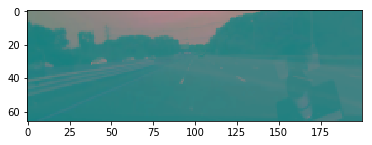

In [22]:
import matplotlib.pyplot as plt 
%matplotlib inline
plt.imshow(img)


### Crop

(330, 1280, 3)


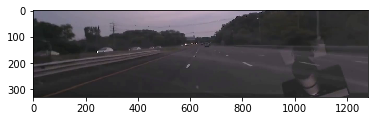

In [7]:
# Chop off 1/3 from the top and cut bottom 150px(which contains the head of car) img[240:570,:,:]
shape = img.shape
img_crop = img[int(shape[0]/3):shape[0]-150, 0:shape[1]]
plt.imshow(img_crop)
print(img_crop.shape)

### Resize

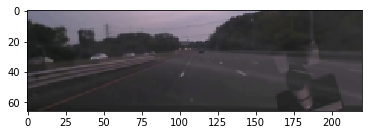

In [8]:
# from scipy.misc import imresize,imsave ,imread
# img_resize = imresize(img_crop.copy(),(66,220))  # 宽 cols（width) ，高 rows (height)

# Resize the image
img_resize = cv2.resize(img_crop, (220, 66), interpolation=cv2.INTER_AREA)
plt.imshow(img_resize)
# imsave('img_resize.jpg',img_resize)

### RGB to YUV

![RGB2YUV](RGBtoYUV.png)

(66, 220, 3)

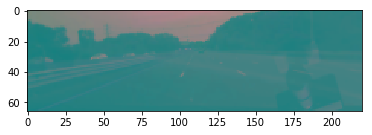

In [9]:
# use cv2
img_yuv = cv2.cvtColor(img_resize, cv2.COLOR_BGR2YUV)
plt.imshow(img_yuv)
img_yuv.shape

In [ ]:
# y, u, v = cv2.split(img_yuv)  
# cv2.imshow("y", y)  
# cv2.imshow("u", u)  
# cv2.imshow("v", v)  
# cv2.waitKey(0)  

In [27]:
img_yuv[5:10,5:10,0]

array([[120, 120, 121, 122, 121],
       [120, 120, 121, 121, 121],
       [117, 117, 120, 120, 120],
       [ 92,  92, 105, 113, 117],
       [ 49,  44,  57,  72,  79]], dtype=uint8)

In [26]:
Y = 0.299*img_resize[:,:,0] + 0.587*img_resize[:,:,1]+0.114*img_resize[:,:,2]
Y[5:10,5:10]

array([[ 120.28 ,  119.867,  121.155,  121.568,  121.28 ],
       [ 119.704,  119.693,  120.981,  120.867,  121.166],
       [ 117.248,  116.878,  120.166,  119.753,  120.166],
       [  92.265,   91.781,  105.069,  113.482,  116.895],
       [  48.983,   44.385,   56.972,   72.499,   78.613]])

In [25]:
U = -0.169*img_resize[:,:,0]  -0.331*img_resize[:,:,1]+0.5*img_resize[:,:,2]+128
U[5:10,5:10]

array([[ 138.   ,  137.669,  137.507,  137.838,  138.   ],
       [ 138.324,  138.331,  138.169,  137.669,  137.5  ],
       [ 136.324,  137.662,  137.5  ,  137.169,  137.5  ],
       [ 133.493,  134.331,  134.169,  134.5  ,  134.831],
       [ 130.831,  131.169,  130.838,  131.669,  132.169]])

In [23]:
V = 0.5*img_resize[:,:,0]  -0.419*img_resize[:,:,1]-0.081*img_resize[:,:,2]+128
V[5:10,5:10]

array([[ 126.38 ,  125.961,  125.042,  125.461,  126.38 ],
       [ 128.218,  126.799,  125.88 ,  125.961,  126.461],
       [ 128.542,  127.38 ,  126.461,  126.042,  126.461],
       [ 128.528,  127.447,  126.528,  126.947,  127.366],
       [ 128.014,  127.014,  126.595,  126.933,  126.852]])

In [15]:
def return_min_max(twoD_array):
    return np.min(twoD_array),np.max(twoD_array)
print("img_yuv[0] min and max: ",return_min_max(img_yuv[0]) )
print("img_yuv[1] min and max: ",return_min_max(img_yuv[2]) )
print("img_yuv[2] min and max: ",return_min_max(img_yuv[2]) )

img_yuv[0] min and max:  (44, 185)
img_yuv[1] min and max:  (43, 174)
img_yuv[2] min and max:  (43, 174)


True

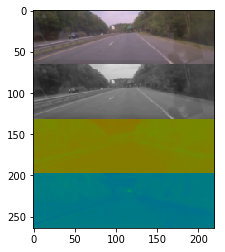

In [64]:
import cv2
import numpy as np


def make_lut_u():
    return np.array([[[i,255-i,0] for i in range(256)]],dtype=np.uint8)

def make_lut_v():
    return np.array([[[0,255-i,i] for i in range(256)]],dtype=np.uint8)


# img = cv2.imread('shed.png')

img_yuv = cv2.cvtColor(img_resize.copy(), cv2.COLOR_BGR2YUV)
y, u, v = cv2.split(img_yuv)

lut_u, lut_v = make_lut_u(), make_lut_v()

# Convert back to BGR so we can apply the LUT and stack the images
y = cv2.cvtColor(y, cv2.COLOR_GRAY2BGR)
u = cv2.cvtColor(u, cv2.COLOR_GRAY2BGR)
v = cv2.cvtColor(v, cv2.COLOR_GRAY2BGR)

u_mapped = cv2.LUT(u, lut_u)
v_mapped = cv2.LUT(v, lut_v)

result = np.vstack([img_resize, y, u_mapped, v_mapped])
plt.imshow(result)
cv2.imwrite('img_combo.png', result)

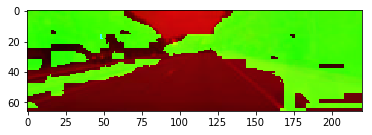

In [126]:
# use skimage
from skimage.color import rgb2yuv
img_yuv2 = rgb2yuv(imread('img_resize.jpg'))
plt.imshow(img_yuv2)

In [74]:
import numpy as np

def RGB2YUV(rgb):
    m = np.array([[ 0.29900, -0.16874,0.50000],
                 [0.58700, -0.33126, -0.41869],
                 [ 0.11400, 0.50000, -0.08131]])
    yuv = np.dot(rgb,m)
#     yuv[:,:,1:]+=128.0
    return yuv

# def YUV2RGB(yuv):       
#     m = np.array([[ 1.0, 1.0, 1.0],
#                  [-0.000007154783816076815, -0.3441331386566162, 1.7720025777816772],
#                  [ 1.4019975662231445, -0.7141380310058594 , 0.00001542569043522235] ])
#     rgb = np.dot(yuv,m)
#     rgb[:,:,0]-=179.45477266423404
#     rgb[:,:,1]+=135.45870971679688
#     rgb[:,:,2]-=226.8183044444304
#     return rgb

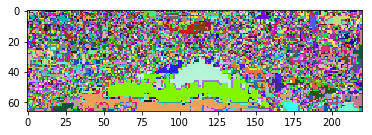

In [140]:
img_yuv3 = RGB2YUV(img_resize.copy())
plt.imshow(img_yuv3)

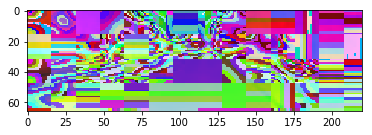

In [141]:
img_yuv4 = RGB2YUV(imread('img_resize.jpg'))
plt.imshow(img_yuv4)

### Normalization

In [159]:
img_nor = img_yuv/255

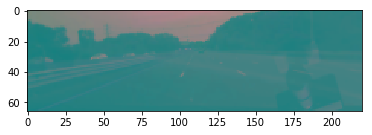

In [14]:
plt.imshow(img_nor)

## data Augumentation

In [2]:
# load data
import h5py

h5f = h5py.File('./data/train.h5','r')
%time X_train10 = h5f['image'][:100]
%time y_train10 = h5f['steering'][:100]
h5f.close()

# h5f2 = h5py.File('./data/test.h5','r')
# %time X_test = h5f2['image'][:]
# %time y_test = h5f2['steering'][:]
# h5f2.close()

CPU times: user 2.83 ms, sys: 38.8 ms, total: 41.7 ms
Wall time: 64.3 ms
CPU times: user 760 µs, sys: 179 µs, total: 939 µs
Wall time: 1.31 ms


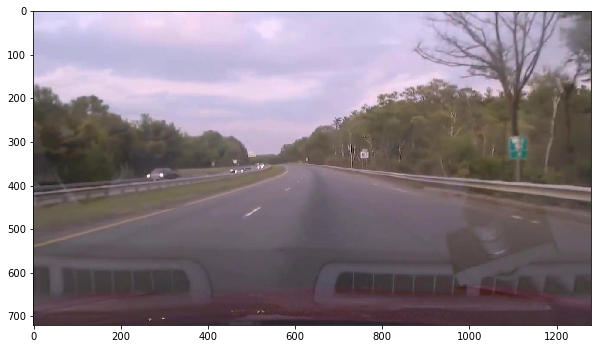

In [18]:
from scipy.misc import imread
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10,6))
file_path = './images_10epoch/epoch10_426_front.jpg'
exp_img = imread(file_path)
plt.imshow(exp_img)

### Flip

In [19]:
from numpy import random
flip_indices = random.sample(range(x.shape[0]), int(x.shape[0] / 2))
x[flip_indices] = x[flip_indices, :, ::-1, :]
y[flip_indices] = -y[flip_indices]


NameError: name 'x' is not defined

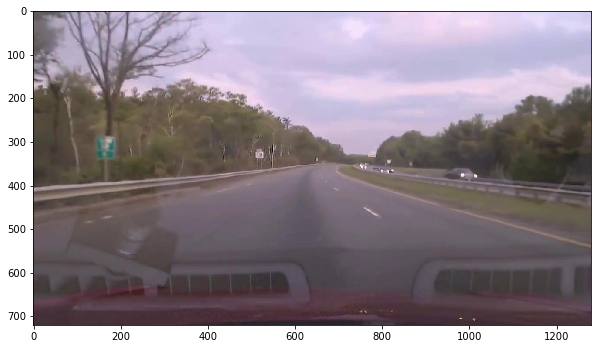

In [20]:
plt.figure(figsize=(10,6))
plt.imshow(exp_img.copy()[:,::-1,:])

### Random shadow

In [40]:
np.random.seed?

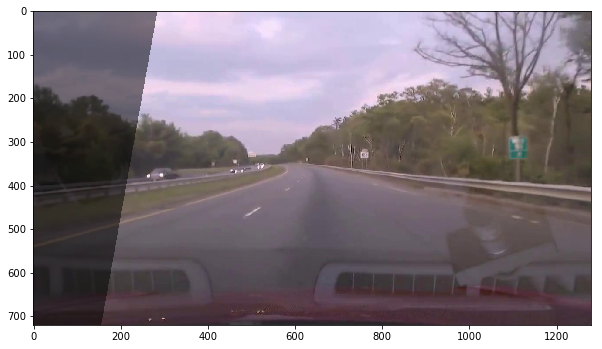

In [21]:
import numpy as np
plt.figure(figsize=(10,6))
plt.imshow(add_shadow(exp_img.copy()))

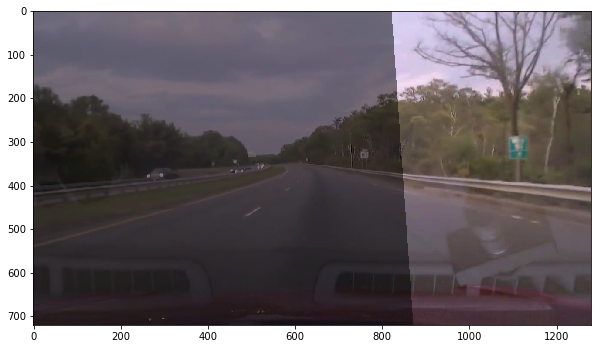

In [22]:
import numpy as np
plt.figure(figsize=(10,6))
plt.imshow(add_shadow(exp_img.copy()))

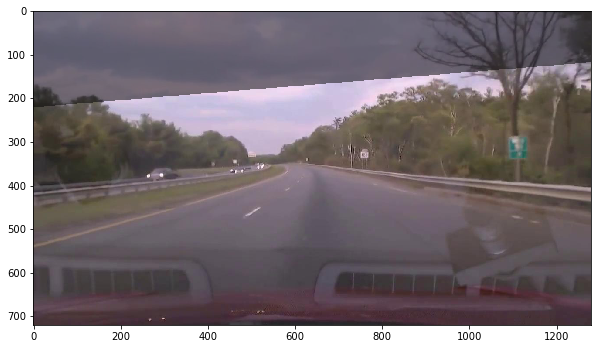

In [23]:
import numpy as np
plt.figure(figsize=(10,6))
plt.imshow(add_shadow(exp_img.copy(),'horizontal'))

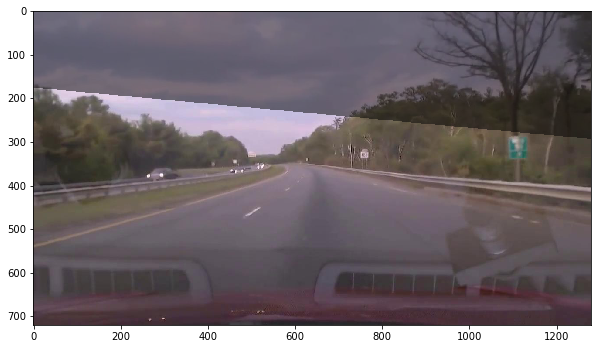

In [24]:
import numpy as np
plt.figure(figsize=(10,6))
plt.imshow(add_shadow(exp_img.copy(),'horizontal'))

In [14]:
h, w = exp_img.shape[:2]
[x1, x2] = np.random.choice(w, 2, replace=False)
k = h / (x2 - x1) #斜率
b = - k * x1  #y轴截距


In [34]:
print(h,w)
print(x1,x2)
print(k,b)

720 1280
1161 785
-1.91489361702 2223.19148936


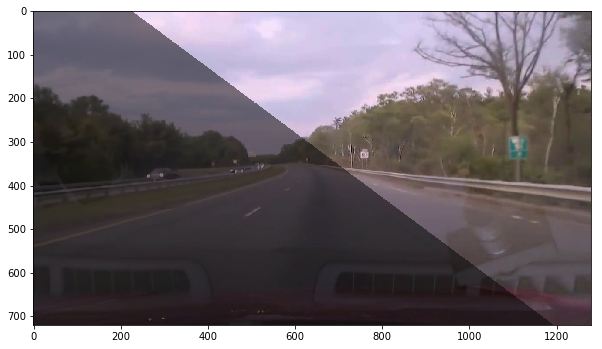

In [25]:
exp_shadow = exp_img.copy()
for i in range(h):
    c = int((i - b) / k)
    exp_shadow[i, :c, :] = (exp_shadow[i, :c, :] * .5) #.astype(np.int32)

plt.figure(figsize=(10,6))
plt.imshow(exp_shadow)    

In [29]:
h, w = exp_img.shape[:2]
[y1, y2] = np.random.choice(h, 2, replace=False)
k = w / (y2 - y1) #斜率
b = - k * y1 #x轴截距
print(h,w)
print(y1,y2)
print(k,b)

720 1280
665 353
-4.10256410256 2728.20512821


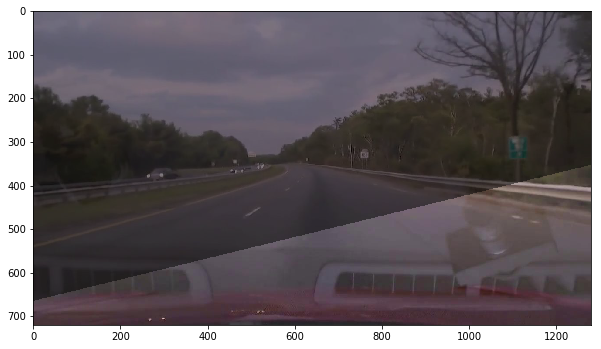

In [31]:
exp_shadow = exp_img.copy()
for i in range(w):
    c = int((i - b) / k)
    exp_shadow[:c, i, :] = (exp_shadow[:c, i, :] * .5).astype(np.int32)

plt.figure(figsize=(10,6))
plt.imshow(exp_shadow)    

## Date generator

In [ ]:
import numpy as np
import skimage.transform as sktransform
import random
import matplotlib.image as mpimg
import os


# Cameras we will use
cameras = ['left', 'center', 'right']
cameras_steering_correction = [.25, 0., -.25]

def preprocess(image, top_offset=.375, bottom_offset=.125):
    """
    Applies preprocessing pipeline to an image: crops `top_offset` and `bottom_offset`
    portions of image, resizes to 32x128 px and scales pixel values to [0, 1].
    """
    top = int(top_offset * image.shape[0])
    bottom = int(bottom_offset * image.shape[0])
    image = sktransform.resize(image[top:-bottom, :], (32, 128, 3))
    return image

def generate_samples(data, root_path, augment=True):
    """
    Keras generator yielding batches of training/validation data.
    Applies data augmentation pipeline if `augment` is True.
    """
    while True:
        # Generate random batch of indices
        indices = np.random.permutation(data.count()[0])
        batch_size = 128
        for batch in range(0, len(indices), batch_size):
            batch_indices = indices[batch:(batch + batch_size)]
            # Output arrays
            x = np.empty([0, 32, 128, 3], dtype=np.float32)
            y = np.empty([0], dtype=np.float32)
            # Read in and preprocess a batch of images
            for i in batch_indices:
                # Randomly select camera
                camera = np.random.randint(len(cameras)) if augment else 1
                # Read frame image and work out steering angle
                image = mpimg.imread(os.path.join(root_path, data[cameras[camera]].values[i].strip()))
                angle = data.steering.values[i] + cameras_steering_correction[camera]
                if augment:
                    # Add random shadow as a vertical slice of image
                    h, w = image.shape[0], image.shape[1]
                    [x1, x2] = np.random.choice(w, 2, replace=False)
                    k = h / (x2 - x1)
                    b = - k * x1
                    for i in range(h):
                        c = int((i - b) / k)
                        image[i, :c, :] = (image[i, :c, :] * .5).astype(np.int32)
                # Randomly shift up and down while preprocessing
                v_delta = .05 if augment else 0
                image = preprocess(
                    image,
                    top_offset=random.uniform(.375 - v_delta, .375 + v_delta),
                    bottom_offset=random.uniform(.125 - v_delta, .125 + v_delta)
                )
                # Append to batch
                x = np.append(x, [image], axis=0)
                y = np.append(y, [angle])
            # Randomly flip half of images in the batch
            flip_indices = random.sample(range(x.shape[0]), int(x.shape[0] / 2))
            x[flip_indices] = x[flip_indices, :, ::-1, :]
            y[flip_indices] = -y[flip_indices]
            yield (x, y)